In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
# Word Cloud
from wordcloud import WordCloud
# from textacy import preprocessing
from nltk.stem.snowball import SnowballStemmer
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import re

In [2]:
df = pd.read_csv("training/text.csv")
df.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


Check for and remove null/duplicate values

In [3]:
# null values
df.isnull().sum()

Unnamed: 0    0
text          0
label         0
dtype: int64

In [4]:
# duplicate values
df.duplicated().sum()

0

Rename the columns

In [5]:
# rename columns
df.rename(columns={'text': 'Text', 'label': 'Label'}, inplace=True)
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()


,Text,Label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


Rename Labels
- 0: 'sadness'
- 1: 'joy'
- 2: 'love'
- 3: 'anger'
- 4: 'fear'
- 5: 'surprise'

In [6]:
df['Label'] = df['Label'].replace(0, 'Sadness')
df['Label'] = df['Label'].replace(1, 'Joy')
df['Label'] = df['Label'].replace(2, 'Love')
df['Label'] = df['Label'].replace(3, 'Anger')
df['Label'] = df['Label'].replace(4, 'Fear')
df['Label'] = df['Label'].replace(5, 'Surprise')

df.head()

,Text,Label
0,i just feel really helpless and heavy hearted,Fear
1,ive enjoyed being able to slouch about relax a...,Sadness
2,i gave up my internship with the dmrg and am f...,Fear
3,i dont know i feel so lost,Sadness
4,i am a kindergarten teacher and i am thoroughl...,Fear


## Analysis

Get the value count of each label and plot it to understand the distribution of the emotions

In [7]:
# get the count of labels
count = df['Label'].value_counts()
count

Label
Joy         141067
Sadness     121187
Anger        57317
Fear         47712
Love         34554
Surprise     14972
Name: count, dtype: int64

C:\Users\epicr\AppData\Local\Temp\ipykernel_23888\1074132917.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count.index, y=count, ax=ax[1], palette='viridis')


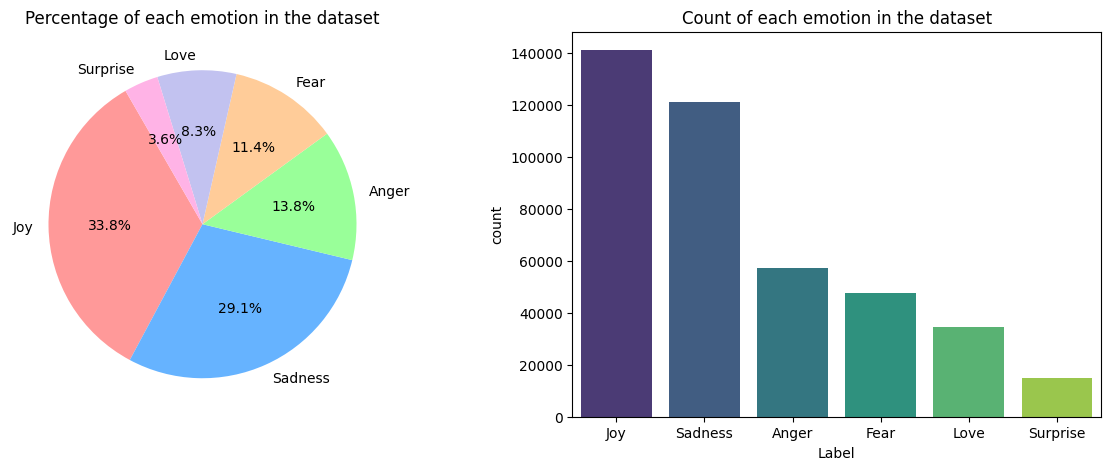

In [8]:
# create 2 subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 5), facecolor='white')

# create pie chart for the first subplot
ax[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=120, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0','#ffb3e6'])
ax[0].set_title('Percentage of each emotion in the dataset')

# create bar chart for the second subplot
sns.barplot(x=count.index, y=count, ax=ax[1], palette='viridis')
ax[1].set_title('Count of each emotion in the dataset')

plt.show()

Create datasets to visualize text for each category

In [9]:
#Sadness
df_sadness = df[df['Label'] == 'Sadness']
#Joy
df_joy = df[df['Label'] == 'Joy']
#Love
df_love = df[df['Label'] == 'Love']
#Anger
df_anger = df[df['Label'] == 'Anger']
#Fear
df_fear = df[df['Label'] == 'Fear']
#Surprise
df_surprise = df[df['Label'] == 'Surprise']

Visualize text with word clouds

Word cloud can help us better understand which words correspond with a specific emotion and by what frequency

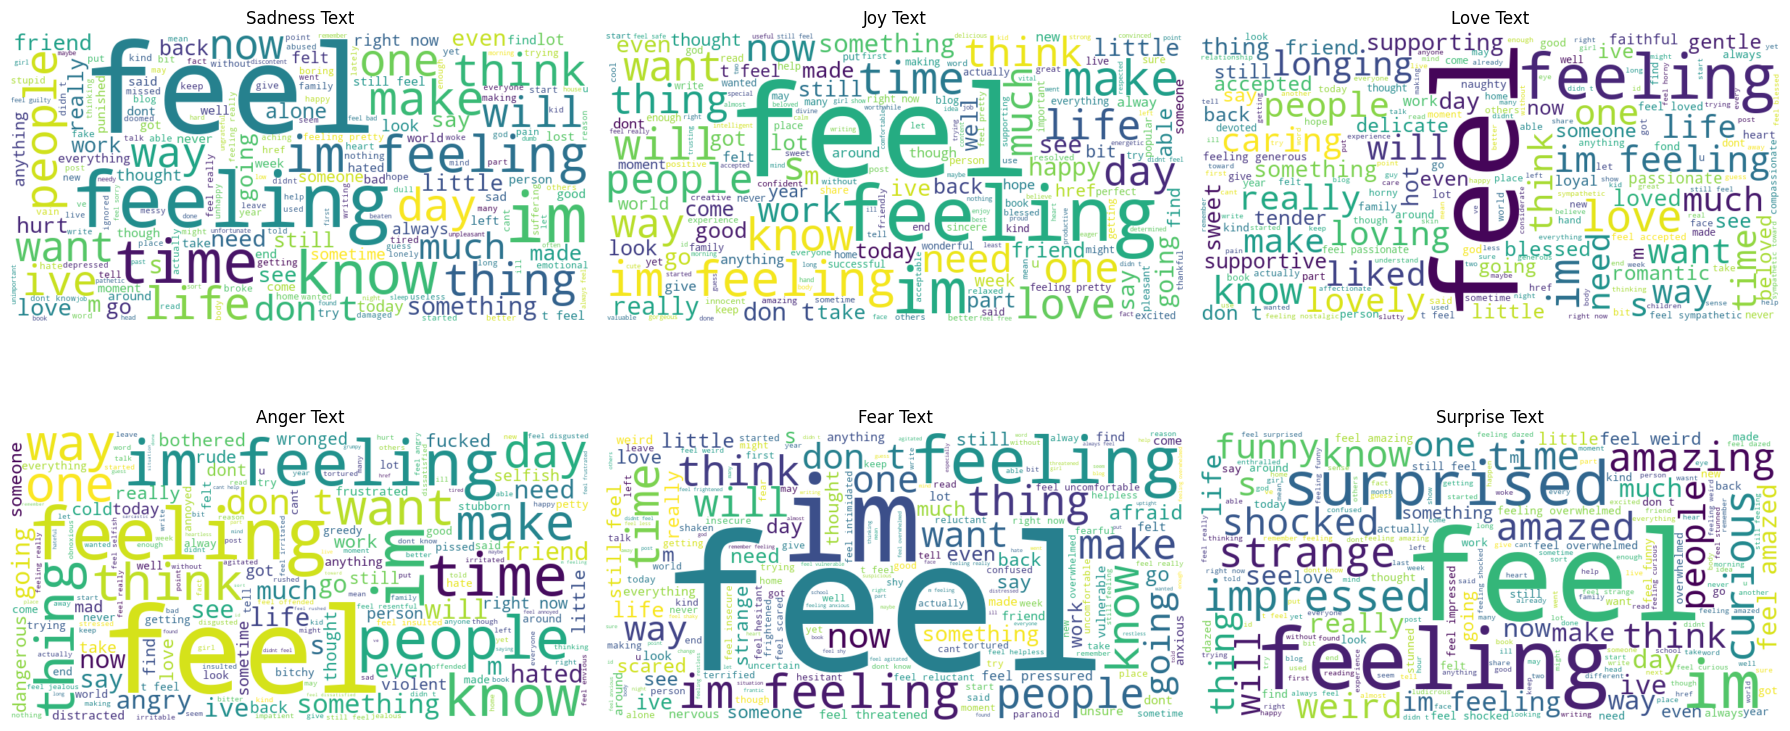

In [10]:
def create_and_plot_wordcloud(text, title, subplot_position):
    """Helper function to generate and plot word cloud."""
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.subplot(2, 3, subplot_position)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')

# Combine text from different categories
combined_texts = {
    'Sadness Text': ' '.join(df_sadness['Text']),
    'Joy Text': ' '.join(df_joy['Text']),
    'Love Text': ' '.join(df_love['Text']),
    'Anger Text': ' '.join(df_anger['Text']),
    'Fear Text': ' '.join(df_fear['Text']),
    'Surprise Text': ' '.join(df_surprise['Text'])
}

# Plot all word clouds
plt.figure(figsize=(18, 9))

for idx, (title, text) in enumerate(combined_texts.items(), start=1):
    create_and_plot_wordcloud(text, title, idx)

plt.tight_layout()
plt.show()


Encode the emotions again (from 0-5)

In [11]:
df['Label'] = df['Label'].replace('Sadness', 0)
df['Label'] = df['Label'].replace('Joy', 1)
df['Label'] = df['Label'].replace('Love', 2)
df['Label'] = df['Label'].replace('Anger', 3)
df['Label'] = df['Label'].replace('Fear', 4)
df['Label'] = df['Label'].replace('Surprise', 5)

df.head()

C:\Users\epicr\AppData\Local\Temp\ipykernel_23888\3918737056.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Label'] = df['Label'].replace('Surprise', 5)


,Text,Label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


## Text Preprocessing

We should make the text as least bias as possible, removing anything that takes away from the meaning from the sentence

1. Remove URLS
2. Remove special characters / punctuation
3. Remove extra whitespaces
4. Remove numeric values
5. Convert to lowercase
6. Remove stop words (common words that don't change the meaning of the sentence)
7. Remove non-alphanumeric characters

In [59]:
# Import nlkt and stemming libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer


# Download the stopwords
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\epicr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\epicr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [60]:
# 1. remove urls
df['Text'] = df['Text'].str.replace(r'http\S+', '', regex=True)

# 2. remove special characters/punctuation
df['Text'] = df['Text'].str.replace(r'[^\w\s]', '', regex=True)

# 3. remove extra whitespaces
df['Text'] = df['Text'].str.replace(r'\s+', ' ', regex=True)

# 4. remove numeric values
df['Text'] = df['Text'].str.replace(r'\d+', '', regex=True)

# 5. convert text to lowercase
df['Text'] = df['Text'].str.lower()

# 6. remove stopwords and apply stemming
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))
df['Text'] = df['Text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split() if word.lower() not in stop_words]))

# 7. remove non-alphanumeric characters
df['Text'] = df['Text'].apply(lambda x: re.sub(r'\W', ' ', x))

df.head()

,Text,Label
0,feel realli helpless heavi heart,4
1,ive enjoy abl slouch relax unwind frankli need...,0
2,gave internship dmrg feel distraught,4
3,dont know feel lost,0
4,kindergarten teacher thoroughli weari job take...,4


## Machine Learning

Train-Test Split

In [61]:
X = df['Text']
y = df['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Get the shape of the training and testing datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (333447,)
X_test shape: (83362,)
y_train shape: (333447,)
y_test shape: (83362,)


Tokenization and Padding

This is necessary to further process and model the data. Models understand numbers, not words like "sad" or "angry". We need to make the data readable in this way for the model to understand and create patterns.

1. Tokenization - Converts the text data into sequences of integers. Each unique word is assigned a unique integer index. X_train and X_test are tokenized.

2. Padding - Ensures uniform length by adding 0 vectors to the end or start. Need to know maximum length of a sentence to make them all the same length.  

In [62]:
# Tokenize the text
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [63]:
# Get the maximum length in X_train_sequences

maxlen = max(len(tokens) for tokens in X_train_sequences)
print("Maximum sequence length (maxlen):", maxlen)


Maximum sequence length (maxlen): 79


In [64]:
# Perform padding on X_train and X_test sequences

X_train_padded = pad_sequences(X_train_sequences, maxlen=maxlen, padding='post',)
X_test_padded = pad_sequences(X_test_sequences, maxlen=maxlen, padding='post')

# Print the padded sequences for X_train and X_test
print("X_train_padded:")
print(X_train_padded)
print("\nX_test_padded:")
print(X_test_padded)



X_train_padded:
[[  21 9730   84 ...    0    0    0]
 [ 306    6  750 ...    0    0    0]
 [   1   51  747 ...    0    0    0]
 ...
 [   1  625    0 ...    0    0    0]
 [   3   19  477 ...    0    0    0]
 [   1  170  847 ...    0    0    0]]

X_test_padded:
[[ 145   30  201 ...    0    0    0]
 [1076 8947  766 ...    0    0    0]
 [ 225  288   54 ...    0    0    0]
 ...
 [ 382   46 1103 ...    0    0    0]
 [1627 5023  621 ...    0    0    0]
 [  90    1  300 ...    0    0    0]]


We need to calculate the input size (vocabulary size) for the embedding layer in our neural network model.

Embedding layer transforms categorical data into dense numberical vectors that our model can process.

One-hot vectors don't capture relationships between words; embeddings allow words with similar meanings to have vector representations and enables model to learn semantic relationships.

Input size: # unique words (or tokens) in the dataset. This tells the embedding layer how many unique tokens it needs to handle.

In [72]:
# # Get the input (vocabulary) size
# input_Size = np.max(X_train_padded) + 1
# input_Size

input_size = len(tokenizer.word_index) + 1
input_size

51151

### Building the model

In [73]:
# Define the model
model = Sequential()

# Add an embedding layer
model.add(Embedding(input_dim=input_size, output_dim=128, input_length=max_length))

# Dropout layer
model.add(Dropout(0.5))

# Add a bidirectional LSTM layer
model.add(Bidirectional(GRU(120, return_sequences=True)))
model.add(Bidirectional(GRU(64, return_sequences=True)))

# Batch normalization layer
model.add(BatchNormalization())

# Add Bidirectional GRU layer
model.add(Bidirectional(GRU(64)))

# Add output layer
model.add(Dense(6, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

c:\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_14                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Model Fitting

In [74]:
history = model.fit(X_train_padded, y_train, epochs=5, batch_size=1500, validation_data=(X_test_padded, y_test))


Epoch 1/5
223/223 ━━━━━━━━━━━━━━━━━━━━ 903s 4s/step - accuracy: 0.6240 - loss: 0.9893 - val_accuracy: 0.8626 - val_loss: 0.6547
Epoch 2/5
223/223 ━━━━━━━━━━━━━━━━━━━━ 700s 3s/step - accuracy: 0.9219 - loss: 0.1641 - val_accuracy: 0.9176 - val_loss: 0.1711
Epoch 3/5
223/223 ━━━━━━━━━━━━━━━━━━━━ 704s 3s/step - accuracy: 0.9279 - loss: 0.1388 - val_accuracy: 0.9188 - val_loss: 0.1453
Epoch 4/5
223/223 ━━━━━━━━━━━━━━━━━━━━ 729s 3s/step - accuracy: 0.9304 - loss: 0.1291 - val_accuracy: 0.9197 - val_loss: 0.1441
Epoch 5/5
223/223 ━━━━━━━━━━━━━━━━━━━━ 727s 3s/step - accuracy: 0.9329 - loss: 0.1226 - val_accuracy: 0.9187 - val_loss: 0.1445


In [69]:
print(X_train_padded.shape, y_train.shape)
print(X_test_padded.shape, y_test.shape)


(333447, 79) (333447,)
(83362, 79) (83362,)


In [75]:
model.evaluate(X_test_padded, y_test)


2606/2606 ━━━━━━━━━━━━━━━━━━━━ 78s 30ms/step - accuracy: 0.9186 - loss: 0.1442


[0.1444949358701706, 0.9186919927597046]

In [86]:
# use the model and an example text to predict the emotion

def clean_text(text):
    # remove urls
    text = re.sub(r'http\S+', '', text)
    # remove special characters/punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # remove extra whitespaces
    text = re.sub(r'\s+', ' ', text)
    # remove numeric values
    text = re.sub(r'\d+', '', text)
    # convert text to lowercase
    text = text.lower()
    # remove stopwords and apply stemming
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    text = ' '.join([stemmer.stem(word) for word in text.split() if word.lower() not in stop_words])
    # remove non-alphanumeric characters
    text = re.sub(r'\W', ' ', text)
    return text

def predict_emotion(text):
    # clean the text
    cleaned_text = clean_text(text)
    # tokenize the text
    tokenized_text = tokenizer.texts_to_sequences([cleaned_text])
    # pad the tokenized text
    padded_text = pad_sequences(tokenized_text, maxlen=maxlen, padding='post')
    # get the prediction
    prediction = model.predict(padded_text)
    # get the emotion
    emotion = np.argmax(prediction)
    # convert the emotion to the corresponding label
    if emotion == 0:
        emotion = 'Sadness'
    elif emotion == 1:
        emotion = 'Joy'
    elif emotion == 2:
        emotion = 'Love'
    elif emotion == 3:
        emotion = 'Anger'
    elif emotion == 4:
        emotion = 'Fear'
    elif emotion == 5:
        emotion = 'Surprise'

    return emotion

# example text
text = "I love you"

# predict the emotion
emotion = predict_emotion(text)

# print the emotion
print(emotion)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Fear
